# Implement Beer Distribution Game as Described by John Sterman (1989)

## Reference

 - John Sterman (1989). Modeling Managerial Behavior: Misperceptions of Feedback in a Dynamic Decision Making Experiment, Management Science, Vol. 35, No. 3 (Mar., 1989), pp. 321-339, https://www.jstor.org/stable/2631975. 


## Introduction

The stock management control problem is divided into two parts:

 1. the stock and flow structure of the system
 2. the decision rule used by the manager

## System diagram

<img src="images/Sterman_1989_fig1_stock_system.png">


### Variables

 - $S(t)$ : Stock level at time $t$ (i.e. inventory).
 - $A(t)$ : Acquisition rate at time $t$ (i.e. additions to stock, such as deliveries from the supplier).
 - $L(t)$ : Loss rate at time $t$ (i.e. reductions from stock, such as shipments to the customer).
 - $O(t)$ : Actual orders at time $t$, $O(t) \ge 0$.
 - ${IO}(t)$ : Indicated orders at time $t$.
 - $\hat{L}(t)$ : Expected stock losses at time $t$.
 - ${AS}(t)$ : Difference between desired and actual stock at time $t$.
 - ${ASL}(t)$ : Difference between desired and actual supply line at time $t$.
 - $S^*(t)$ : Desired stock level at time $t$.
 - ${SL}^*(t)$ : Desired supply line level at time $t$.
 - $\alpha_{s}$ : Decision rule parameter – the adjustment rate for the stock.
 - $\alpha_{sl}$ : Decision rule parameter – the adjustment rate for the supply line.
 - $\hat{\lambda}(t)$ : Expected lag between ordering and acquisition of goods.
 - $\Phi^*(t)$ : Desired throughput.

### Stock and flow system model

The stock at the next time instant $S(t+1)$ is given by the stock in the current time instant plus the current accumulation and loss rates (I assume the accumulation and loss rates are defined in units / period and are constant during each period),

\begin{equation}
S(t+1) = A(t) - L(t) + S(t). \tag{1}
\end{equation}

The acquisition rate depends on the supply line of units, $SL(t)$, which have been ordered but not yet received, and the average acquisition lag, $\lambda$. The supply line at the next time instant is simply the accumulation of the orders placed in the current period $O(t)$, less those which have been delivered $A(t)$:

\begin{equation}
SL(t+1) = O(t) - A(t) + {SL}(t). \tag{2}
\end{equation}


### Management decision rule

Managers are assumed to choose orders so as to:
 1. replace expected losses from stock
 2. reduce the discrepancy between the desired and actual stock
 3. maintain an adequate supply line of unfilled orders.

Note that orders must be non-negative, therefore

\begin{equation}
O(t) = \max(0, IO(t)). \tag{3}
\end{equation}

The indicated order rate is based on the anchoring and 
adjustment heuristic (Tversky and Kahneman 1974).
Anchoring and adjustment is a common strategy in which 
an unknown quantity is estimated by first recalling a
known reference point (the anchor) and then adjusting
for the effects of other factors which may be less
salient or whose effects are obscure, requiring the
subject to estimate these effects by what Kahneman and
Tversky (1982) call 'mental simulation.' Here, the
anchor is the expected loss rate $L$. Adjustments are then
made to correct discrepancies between the desired and
actual stock ($AS$), and between the desired and actual 
supply line ($ASL$).

\begin{equation}
IO(t) = \hat{L}(t) + AS(t) + ASL(t). \tag{4}
\end{equation}

There is a negative feedback loop which regulates the stock level.  The adjustment rate is linear in the discrepancy between the desired stock $S^*(t)$ and the actual stock:

\begin{equation}
AS(t) = \alpha_s (S^*(t) - S(t)). \tag{5}
\end{equation}

where $\alpha_s$ is the stock adjustment parameter.

Similarly, there is a second feedback loop which regulates the supply line level.  The adjustment rate is linear in the discrepancy between the desired supply line level $S^*(t)$ and the actual:

\begin{equation}
ASL(t) = \alpha_sl (SL^*(t) - SL(t)). \tag{6}
\end{equation}

where $\alpha_s$ is the stock adjustment parameter.

The desired supply line in general is not constant but depends on the desired throughput, $\Phi^*(t)$ and the expected lag between ordering and acquisition of goods:

\begin{equation}
SL^*(t) = \hat{\lambda}(t) \cdot \Phi^*(t). \tag{7}
\end{equation}

## Functions to implement system model

In [1]:
from collections import deque
import numpy as np
import prettytable
from prettytable import PrettyTable

In [2]:
def calc_stock_tp1(stock_t, acquisition_rate_t, loss_rate_t, dt=1):
    """Calculate stock at time t

        S(t+1) = S(t) + (A(t) - L(t)) * dt

    This is a discrete-time version of Eqn. 1 in Sterman (1989).
    """
    assert acquisition_rate_t >= 0
    assert loss_rate_t >= 0

    stock_tp1 = stock_t + (acquisition_rate_t - loss_rate_t) * dt

    assert stock_tp1 >= 0, "Negative stock"

    return stock_tp1

# Test
assert calc_stock_tp1(10, 4, 3, 1) == 11
assert calc_stock_tp1(10, 4, 3, 0.5) == 10.5
assert calc_stock_tp1(5, 0, 5) == 0
try:
    calc_stock_tp1(5, 0, 6)
except AssertionError:
    pass
else:
    assert False

In [3]:
def calc_supply_line_tp1(supply_line_t, items_shipped_t, dt=1):
    """Calculate supply line at time t

        SL(t+1) = SL(t) + (O(t) - A(t)) * dt

    This is a discrete-time version of Eqn. 2 in Sterman (1989).
    """
    assert items_shipped_t >= 0

    # Get last shipment from the end of the supply line
    acquisition_rate_t = supply_line_t.pop()

    # Add new shipment to the start of the supply line
    supply_line_t.appendleft(items_shipped_t)

    return acquisition_rate_t, supply_line_t

# Test
assert calc_supply_line_tp1(deque([3, 2, 1]), 4) == (1, deque([4, 3, 2]))

In [4]:
def update_stage_state(stage_states, incoming_orders_t, 
                       supplies_delivered_t, dt=1):

    assert incoming_orders_t >= 0
    assert supplies_delivered_t >= 0

    # Get current stock level
    stock_t = stage_states['stock']

    # Total orders including backlog
    total_orders = stage_states['unfilled_orders'] + incoming_orders_t

    # Ship items if in stock
    products_shipped_t = np.clip(total_orders, 0, stock_t)

    # Remaining unfilled order backlog
    stage_states['unfilled_orders'] = total_orders - products_shipped_t

    # Get current supply line
    supply_line_t = stage_states['supply_line']

    # Calculate supply line at next time instant
    acquisition_rate_t, supply_line_tp1 = \
        calc_supply_line_tp1(supply_line_t, supplies_delivered_t, dt=dt)

    # Calculate stock level at next time instant
    stock_tp1 = calc_stock_tp1(stock_t, acquisition_rate_t, 
                               products_shipped_t, dt=dt)

    # Save updated states
    stage_states['supply_line'] = supply_line_tp1
    stage_states['stock'] = stock_tp1

    return products_shipped_t


# Test
stage_states = {'unfilled_orders': 0, 'stock': 5, 'supply_line': deque([2, 2])}
incoming_orders_t = 4
supplies_delivered_t = 4
products_shipped_t = update_stage_state(stage_states, incoming_orders_t, supplies_delivered_t, dt=1)
assert stage_states == {'unfilled_orders': 0, 'stock': 3, 'supply_line': deque([4, 2])}
assert products_shipped_t == 4

incoming_orders_t = 3
supplies_delivered_t = 5
products_shipped_t = update_stage_state(stage_states, incoming_orders_t, supplies_delivered_t, dt=1)
assert stage_states == {'unfilled_orders': 0, 'stock': 2, 'supply_line': deque([5, 4])}
assert products_shipped_t == 3

incoming_orders_t = 10
supplies_delivered_t = 1
products_shipped_t = update_stage_state(stage_states, incoming_orders_t, supplies_delivered_t, dt=1)
assert stage_states == {'unfilled_orders': 8, 'stock': 4, 'supply_line': deque([1, 5])}
assert products_shipped_t == 2

## Functions to implement decision rule

In [5]:
def calc_orders_t(expected_losses_t, adjustment_for_stock_t, adjustment_for_supply_line_t):
    """Calculate order decision at time t

        IO(t) = L_hat(t) + AS(t) + ASL(t)
        O(t) = max(0, IO(t))

    These are discrete-time versions of Eqn.s 3 and 4 in Sterman (1989).
    """
    indicated_orders = expected_losses_t + adjustment_for_stock_t + adjustment_for_supply_line_t
    return np.clip(indicated_orders, 0, None)

# Test
assert calc_orders_t(1, 2, 3) == 6
assert calc_orders_t(1, 2, -3) == 0
assert calc_orders_t(1, 2, -10) == 0

In [6]:
def calc_adjustment_for_stock_t(stock_t, stock_target_t, alpha_s):
    """Calculate order adjustment for stock discrepancy at time t

        AS(t) = alpha_s * (S_target(t) - S(t))

    This is a discrete-time version of Eqn. 5 in Sterman (1989).
    """
    return alpha_s * (stock_target_t - stock_t)

# Test
assert calc_adjustment_for_stock_t(10, 12, 0.5) == 1

In [7]:
def calc_adjustment_for_supply_line_t(supply_line_t, supply_line_target_t, alpha_sl):
    """Calculate order adjustment for stock discrepancy at time t

        ASL(t) = alpha_sl * (SL_target(t) - SL(t))

    This is a discrete-time version of Eqn. 6 in Sterman (1989).
    """
    return alpha_sl * (supply_line_target_t - supply_line_t)

# Test
assert calc_adjustment_for_stock_t(12, 10, 0.5) == -1

In [8]:
def calc_supply_line_target_t(lambda_expected_t, throughput_target_t):
    """Calculate order adjustment for stock discrepancy at time t

        SL_target(t) = \lambda_expected(t) * Phi_target(t)

    This is a discrete-time version of Eqn. 7 in Sterman (1989).
    """
    return lambda_expected_t * throughput_target_t

# Test
assert calc_supply_line_target_t(4, 10) == 40

In [9]:
def make_order_decision(stage_states, player_params):

    if player_params['stock_policy'] == 'order_up_to':

        # Calculate adjustment due to stock discrepancy
        stock_t = stage_states['stock']
        stock_target_t = player_params['stock_target']
        alpha_s = player_params['alpha_s']
        adjustment_for_stock_t = \
            calc_adjustment_for_stock_t(stock_t, stock_target_t, 
                                        alpha_s)

        # Calculate throughput target according to policy
        if player_params['throughput_target_policy'] == 'rolling_mean':
            data = player_params['incoming_order_history']
            player_params['throughput_target'] = sum(data) / len(data)
        else:
            raise ValueError(f"Unrecognized policy '{player_params['throughput_target_policy']}'")

        # Calculate adjustment due to supply line discrepancy
        lambda_expected_t = player_params['expected_supply_delay']
        player_params['supply_line_target'] = \
            calc_supply_line_target_t(lambda_expected_t, 
                                      player_params['throughput_target'])
        supply_line_t = np.sum(stage_states['supply_line'])
        alpha_sl = player_params['alpha_sl']
        adjustment_for_supply_line_t = \
            calc_adjustment_for_supply_line_t(supply_line_t, 
                                              player_params['supply_line_target'], 
                                              alpha_sl)
        # Calculate orders
        expected_losses_t = player_params['expected_losses_t']
        orders_t = calc_orders_t(expected_losses_t, 
                                 adjustment_for_stock_t, 
                                 adjustment_for_supply_line_t)

    else:
        raise ValueError(f"Unrecognized policy '{player_params['stock_policy']}'")

    return orders_t

# Test
player_params = {
    'expected_losses_t': 4,
    'expected_supply_delay': 2,
    'stock_target': 12,
    'throughput_target_policy': 'rolling_mean',
    'incoming_order_history': [4, 4, 4],
    'stock_policy': 'order_up_to',
    'alpha_s': 0.5,
    'alpha_sl': 0.5
}
stage_states = {'stock': 12, 'supply_line': deque([4, 4])}
assert make_order_decision(stage_states, player_params) == 4
stage_states = {'stock': 10, 'supply_line': deque([4, 2])}
assert make_order_decision(stage_states, player_params) == 6
stage_states = {'stock': 8, 'supply_line': deque([4, 4])}
assert make_order_decision(stage_states, player_params) == 6
stage_states = {'stock': 12, 'supply_line': deque([2, 2])}
assert make_order_decision(stage_states, player_params) == 6
stage_states = {'stock': 16, 'supply_line': deque([6, 6])}
assert make_order_decision(stage_states, player_params) == 0
stage_states = {'stock': 16, 'supply_line': deque([6, 7])}
assert make_order_decision(stage_states, player_params) == 0

## Beer Game Experiment

<img src="images/Sterman_1989_fig2_beer_game.png">

The players objective is to minimize the total company costs during the game.  Inventory holding costs are \\$.50/case/week, and stockout costs (costs for having a backlog of unfilled orders) are \\$1.00/case/week.  Therefore, Players must keep their inventory as low as possible while avoiding backlogs.

### Steps carried out by each player each turn

1. Receive inventory and advance shipping delays
2. Fill orders
3. Record inventory or backlog on record sheet
4. Advance the order slips
5. Place orders.

### Initialization protocol

The game is initialized in equilibrium.  Each inventory contains 12 cases and initial throughput is four cases per week (see Figure 4). Customer demand likewise begins at four cases per week.  For the first four weeks players are instructed to order four cases per week to maintain the initial equilibrium.  Begining with week four the players are allowed to order any non-negative quantity they wish. There is an unnannounced, one-time increase in customer demand to eight cases per week in week 5. Players are told the game will run for 50 simulated weeks but play is actually halted ater 36 weeks to avoid horizon effects.

In [19]:
game_params = {
    'retailer': {
        'holding_cost': 0.5,
        'stock_out_cost': 1.0,
        'initial_unfilled_orders': 0,
        'initial_stock': 12,
        'initial_supply_line': [4, 4]
    },
    'wholesaler': {
        'holding_cost': 0.5,
        'stock_out_cost': 1.0,
        'initial_unfilled_orders': 0,
        'initial_stock': 12,
        'initial_supply_line': [4, 4]
    },
    'distributer': {
        'holding_cost': 0.5,
        'stock_out_cost': 1.0,
        'initial_unfilled_orders': 0,
        'initial_stock': 12,
        'initial_supply_line': [4, 4]
    },
    'factory': {
        'holding_cost': 0.5,
        'stock_out_cost': 1.0,
        'initial_unfilled_orders': 0,
        'initial_stock': 12,
        'initial_supply_line': [4, 4]
    }
}
customer_demand = [4]*4 + [8]*46

In [20]:
player_params = {
    'retailer': {
        'expected_losses_t': 4,
        'expected_supply_delay': 2,
        'stock_target': 12,
        'throughput_target_policy': 'rolling_mean',
        'incoming_order_history': [4, 4, 4],
        'stock_policy': 'order_up_to',
        'alpha_s': 0.5,
        'alpha_sl': 0.5
    },
    'wholesaler': {
        'expected_losses_t': 4,
        'expected_supply_delay': 2,
        'stock_target': 12,
        'throughput_target_policy': 'rolling_mean',
        'incoming_order_history': [4, 4, 4],
        'stock_policy': 'order_up_to',
        'alpha_s': 0.5,
        'alpha_sl': 0.5
    },
    'distributer': {
        'expected_losses_t': 4,
        'expected_supply_delay': 2,
        'stock_target': 12,
        'throughput_target_policy': 'rolling_mean',
        'incoming_order_history': [4, 4, 4],
        'stock_policy': 'order_up_to',
        'alpha_s': 0.5,
        'alpha_sl': 0.5
    },
    'factory': {
        'expected_losses_t': 4,
        'expected_supply_delay': 2,
        'stock_target': 12,
        'throughput_target_policy': 'rolling_mean',
        'incoming_order_history': [4, 4, 4],
        'stock_policy': 'order_up_to',
        'alpha_s': 0.5,
        'alpha_sl': 0.5
    }
}

In [21]:
def game_states_table(game_states, shipments=None, orders=None, players=None):

    if players is None:
        players = ('retailer', 'wholesaler', 'distributer', 'factory')

    table = PrettyTable(hrules=prettytable.HEADER, vrules=prettytable.NONE)
    table.field_names = [
        'Player', 
        'Unfilled orders', 
        'Stock', 
        'Supply line', 
        'Shipments made',
        'Orders made',
        'Cum. holding cost',
        'Cum. stockout cost'
    ]
    for field in ['Unfilled orders', 'Stock', 'Shipments made', 'Orders made', 
                  'Cum. holding cost', 'Cum. stockout cost']:
        table.float_format[field] = '.1'
    table.custom_format['Supply line'] = lambda f, v: f"{[round(x, 1) for x in v]}"
    if shipments is None:
        shipments = {player: None for player in players}
    if orders is None:
        orders = {player: None for player in players}
    table.align['Player'] = 'l'
    for player in players:
        unfilled_orders = game_states[player]['unfilled_orders']
        stock = game_states[player]['stock']
        supply_line = list(game_states[player]['supply_line'])
        cum_holding_cost = None
        cum_stockout_cost = None
        items = [player, unfilled_orders, stock, supply_line, shipments[player], 
                 orders[player], cum_holding_cost, cum_stockout_cost]
        table.add_row(items)

    return table

# Initial game states
initial_game_states = {
    name: {
        'unfilled_orders': params['initial_unfilled_orders'],
        'stock': params['initial_stock'],
        'supply_line': deque(params['initial_supply_line'])
    }
    for name, params in game_params.items()
}

print(game_states_table(initial_game_states))

  Player        Unfilled orders   Stock   Supply line   Shipments made   Orders made   Cum. holding cost   Cum. stockout cost  
-------------------------------------------------------------------------------------------------------------------------------
  retailer             0            12       [4, 4]          None            None             None                None         
  wholesaler           0            12       [4, 4]          None            None             None                None         
  distributer          0            12       [4, 4]          None            None             None                None         
  factory              0            12       [4, 4]          None            None             None                None         


## Run simulation

In [22]:
players = ('retailer', 'wholesaler', 'distributer', 'factory')

game_states = initial_game_states
sim_out = {
    'Sim data': [],
    'Stocks': [],
    'Supply lines': [],
    'Unfilled orders': []
}

dt = 1
for i in range(len(customer_demand)):

    # Current time instant
    t = i * dt

    # Incoming order for the first player (retailer) is direct
    # from final customer
    next_incoming_order = customer_demand[t]

    # Make order decisions for each player and pass them on to
    # the next downstream player
    incoming_orders_t = {}
    orders_t = {}
    for player in players:

        # Update players record of incoming orders
        order_history = deque(player_params[player]['incoming_order_history'])
        order_history.pop()
        order_history.appendleft(next_incoming_order)
        player_params[player]['incoming_order_history'] = list(order_history)
        incoming_orders_t[player] = next_incoming_order

        orders_t[player] = \
            make_order_decision(game_states[player], player_params[player])
        next_incoming_order = orders_t[player]

    # Assume orders by first stage in supply chain (the factory) are
    # always shipped immediately
    first_stage = players[-1]
    next_supplies_shipped = orders_t[first_stage]

    # Implement order decisions for each player
    supplies_shipped_t = {}
    products_shipped_t = {}
    for player in players:
        supplies_shipped_t[player] = next_supplies_shipped
        products_shipped_t[player] = \
            update_stage_state(game_states[player], incoming_orders_t[player], 
                               supplies_shipped_t[player])

        # Products shipped by this player are supplies shipped 
        # to the upstream player
        next_supplies_shipped = products_shipped_t[player]

    print(f"\nStep {i} : t = {t}, Customer demand = {customer_demand[t]}\n")
    print(game_states_table(game_states, products_shipped_t, orders_t))

    
    # Save simulation data
    sim_out['Sim data'].append({'Time': t})
    sim_out['Stocks'].append({player: game_states[player]['stock'] for player in players})
    sim_out['Supply lines'].append({player: sum(game_states[player]['supply_line']) for player in players})
    sim_out['Unfilled orders'].append({player: game_states[player]['unfilled_orders'] for player in players})



Step 0 : t = 0, Customer demand = 4

  Player        Unfilled orders   Stock   Supply line   Shipments made   Orders made   Cum. holding cost   Cum. stockout cost  
-------------------------------------------------------------------------------------------------------------------------------
  retailer             0            12      [4.0, 4]          4              4.0              None                None         
  wholesaler          0.0          12.0      [4, 4]          4.0             4.0              None                None         
  distributer         0.0          12.0     [4.0, 4]         4.0             4.0              None                None         
  factory             0.0          12.0     [4.0, 4]         4.0             4.0              None                None         

Step 1 : t = 1, Customer demand = 4

  Player        Unfilled orders   Stock   Supply line   Shipments made   Orders made   Cum. holding cost   Cum. stockout cost  
----------------------------

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

sim_results = pd.concat([pd.DataFrame.from_records(data) for data in sim_out.values()], axis=1, keys=sim_out.keys())
sim_results.round(2)

Sim data   Stocks                                Supply lines             \
       Time retailer wholesaler distributer factory     retailer wholesaler   
0         0    12.00      12.00       12.00   12.00         8.00       8.00   
1         1    12.00      12.00       12.00   12.00         8.00       8.00   
2         2    12.00      12.00       12.00   12.00         8.00       8.00   
3         3    12.00      12.00       12.00   12.00         8.00       8.00   
4         4     8.00      10.67       11.56   11.85         8.05      12.00   
5         5     4.00       6.02       10.90   11.93         7.93      16.00   
6         6     4.05       8.00        8.57   13.22         7.10      12.00   
7         7     3.88       8.00        8.64   11.72         4.87       8.05   
8         8     3.22       4.00        6.02    9.59         4.04       7.93   
9         9     1.64       4.05        8.00    8.57         8.78       7.10   
10       10     2.39       3.88        8.00    8.64        18.07       4.87   
11       11     6.38       3.22        4.00    6.02        26.92       4.04   
12       12    11.69       1.64        4.05    8.00        33.11       8.78   
13       13    15.23       2.39        3.88    8.00        36.97      18.07   
14       14    17.88       6.38        3.22    4.00        37.93      26.92   
15       15    19.09      11.69        1.64    4.05        35.96      33.11   
16       16    20.30      15.23        2.39    3.88        30.48      35.51   
17       17    29.42      18.03        6.38    3.22        23.62      25.63   
18       18    34.77      35.66       11.69    1.64        18.25      16.00   
19       19    37.04      43.66       15.08    2.39        12.78      16.00   
20       20    37.03      51.66        0.00    6.38         5.38      16.00   
21       21    33.82      59.66        0.00   11.69         0.59      16.00   
22       22    26.41      66.86        0.00   15.08         4.10      16.00   
23       23    18.41      72.12        0.00    0.00        16.43      16.00   
24       24    14.51      79.53        0.80    0.00        31.60      16.00   
25       25    18.83      87.53        2.75    0.00        37.86      16.00   
26       26    30.11      95.53        0.58    0.00        36.36      16.00   
27       27    40.70     103.53        0.00    0.80        34.65      16.00   
28       28    50.46     111.53        0.00    2.75        34.17      16.00   
29       29    59.35     119.53        0.00    0.58        35.52      16.00   
30       30    68.63     127.53        0.00    0.00        37.95      16.00   
31       31    78.87     135.53        0.00    0.00        39.71      16.00   
32       32    90.58     143.53        0.00    0.00        40.00      16.00   
33       33   102.58     151.53        0.00    0.00        40.00      16.00   
34       34   114.58     159.53        0.00    0.00        40.00      16.00   
35       35   126.58     167.53        0.00    0.00        40.00      16.00   
36       36   138.58     175.53        0.00    0.00        40.00      16.00   
37       37   150.58     183.53        0.00    0.00        40.00      16.00   
38       38   162.58     191.53        0.00    0.00        40.00      16.00   
39       39   174.58     199.53        0.00    0.00        40.00      16.00   
40       40   186.58     207.53        0.00    0.00        40.00      16.00   
41       41   198.58     215.53        0.00    0.00        40.00      16.00   
42       42   210.58     223.53        0.00    0.00        40.00      16.00   
43       43   222.58     231.53        0.00    0.00        40.00      16.00   
44       44   234.58     239.53        0.00    0.00        40.00      16.00   
45       45   246.58     247.53        0.00    0.00        40.00      16.00   
46       46   258.58     255.53        0.00    0.00        40.00      16.00   
47       47   270.58     263.53        0.00    0.00        40.00      16.00   
48       48   282.58     271.53        0.00    0.00  

## Plot results

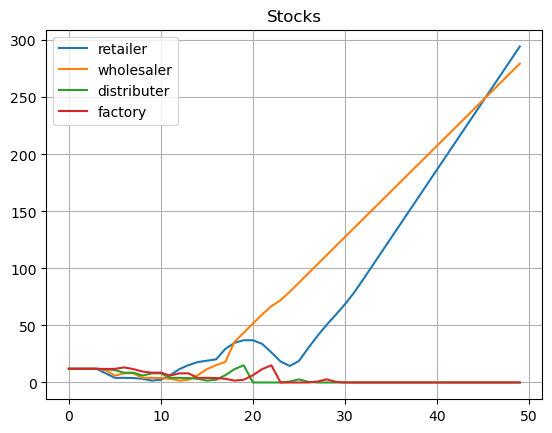

In [24]:
group = 'Stocks'
sim_results[group].plot()
plt.grid()
plt.title(group)
plt.show()

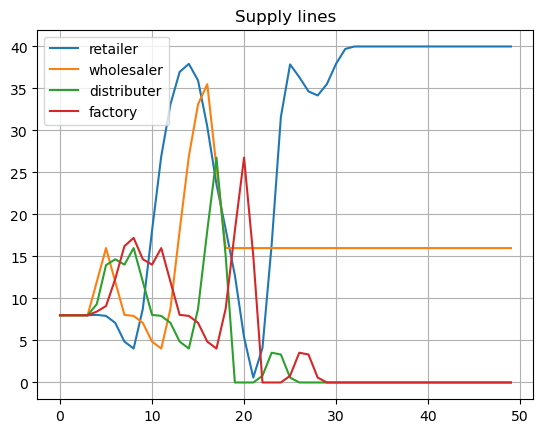

In [25]:
group = 'Supply lines'
sim_results[group].plot()
plt.grid()
plt.title(group)
plt.show()

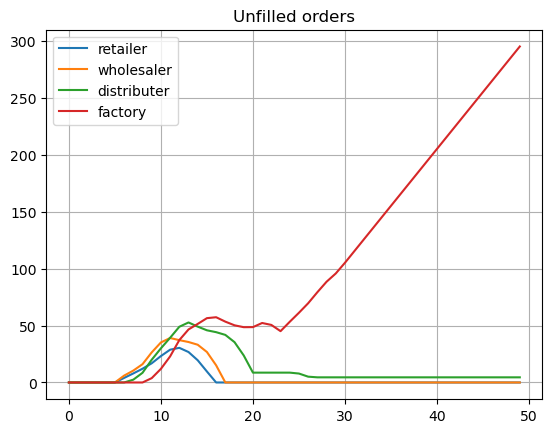

In [26]:
group = 'Unfilled orders'
sim_results[group].plot()
plt.grid()
plt.title(group)
plt.show()

In [27]:
player_params

{'retailer': {'expected_losses_t': 4,
  'expected_supply_delay': 2,
  'stock_target': 12,
  'throughput_target_policy': 'rolling_mean',
  'incoming_order_history': [8, 8, 8],
  'stock_policy': 'order_up_to',
  'alpha_s': 0.5,
  'alpha_sl': 0.5,
  'throughput_target': 8.0,
  'supply_line_target': 16.0},
 'wholesaler': {'expected_losses_t': 4,
  'expected_supply_delay': 2,
  'stock_target': 12,
  'throughput_target_policy': 'rolling_mean',
  'incoming_order_history': [0.0, 0.0, 0.0],
  'stock_policy': 'order_up_to',
  'alpha_s': 0.5,
  'alpha_sl': 0.5,
  'throughput_target': 0.0,
  'supply_line_target': 0.0},
 'distributer': {'expected_losses_t': 4,
  'expected_supply_delay': 2,
  'stock_target': 12,
  'throughput_target_policy': 'rolling_mean',
  'incoming_order_history': [0.0, 0.0, 0.0],
  'stock_policy': 'order_up_to',
  'alpha_s': 0.5,
  'alpha_sl': 0.5,
  'throughput_target': 0.0,
  'supply_line_target': 0.0},
 'factory': {'expected_losses_t': 4,
  'expected_supply_delay': 2,
  'sto